In [2]:
import numpy as np
import scipy.linalg as la
import sympy as sy
import matplotlib.pyplot as plt

In [32]:
def get_cond_num(A):
    s_vals = la.svdvals(A)
    if np.isclose(s_vals[-1], 0):
        return np.inf
    else:
        return s_vals[0] / s_vals[-1]

A = np.random.random((10, 10))
B = la.svd(A)[0]
C = np.array([[1, 0], [1, 0]])


print(get_cond_num(A))
print(np.linalg.cond(A))
print(get_cond_num(B))
print(np.linalg.cond(B))
print(get_cond_num(C))
print(np.linalg.cond(C))

137.90092571
137.90092571
1.0
1.0
inf
inf


/anaconda/lib/python3.6/site-packages/numpy/linalg/linalg.py:1502: RuntimeWarning: divide by zero encountered in true_divide
  return s[..., 0]/s[..., -1]


3.54047553736789e-9
2443593686.57341


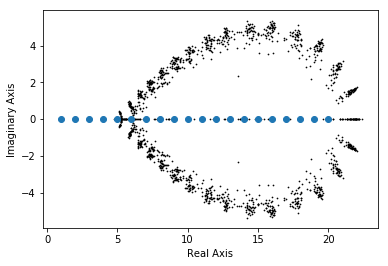

In [63]:
def experiment():
    # The roots of w are 1, 2, ..., 20.
    w_roots = np.arange(1, 21)
    # Get the exact Wilkinson polynomial coefficients using SymPy.
    x, i = sy.symbols('x i')
    w = sy.poly_from_expr(sy.product(x-i, (i, 1, 20)))[0]
    w_coeffs = np.array(w.all_coeffs())
    counter = 0
    acn_sum = 0
    rcn_sum = 0
    while counter < 100:
        # Perturb all of the coefficients very slightly.
        h = np.random.normal(loc=1, scale=1e-10, size=21)
        new_coeffs = w_coeffs * h
        new_roots = np.roots(np.poly1d(new_coeffs))
        plt.scatter(new_roots.real, new_roots.imag, c='k', marker='.', s=2)
        #Compute acn and rcn
        new_roots = np.sort(new_roots)
        k = la.norm(new_roots - w_roots, np.inf) / la.norm(new_coeffs - w_coeffs, np.inf)
        acn_sum += k
        rcn_sum += k * la.norm(w_coeffs, np.inf) / la.norm(w_roots, np.inf)
        counter += 1
    print(acn_sum / 100)
    print(rcn_sum / 100)
    plt.scatter(w_roots, np.zeros_like(w_roots))
    plt.xlabel('Real Axis')
    plt.ylabel('Imaginary Axis')
    plt.show()

experiment()

In [66]:
def est_eig_cn(A):
    reals = np.random.normal(0, 1e-10, A.shape)
    imags = np.random.normal(0, 1e-10, A.shape)
    H = reals + 1j*imags
    A_eigvals = la.eigvals(A)
    Perturbed_eigvals = la.eigvals(A + H)
    acn = la.norm(A_eigvals - Perturbed_eigvals) / la.norm(H)
    rcn = la.norm(A) * acn / la.norm(A_eigvals)
    return acn, rcn

est_eig_cn(np.random.random((2, 2)))

(0.56408190327107477, 0.64315403915195324)

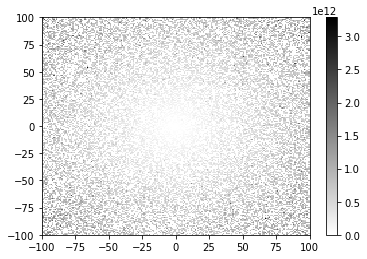

In [77]:
def get_grid(xmin, xmax, ymin, ymax, res):
    x_domain = np.linspace(xmin, xmax, res)
    y_domain = np.linspace(ymin, ymax, res)
    X, Y = np.meshgrid(x_domain, y_domain)
    Z = np.empty((res, res))
    for i in range(res):
        for j in range(res):
            Z[i, j] = est_eig_cn(np.array([[1, X[i, j]], [Y[i, j], 1]]))[1]
    plt.pcolormesh(X, Y, Z, cmap='gray_r')
    plt.colorbar()
    plt.show()

get_grid(-100, 100, -100, 100, 200)

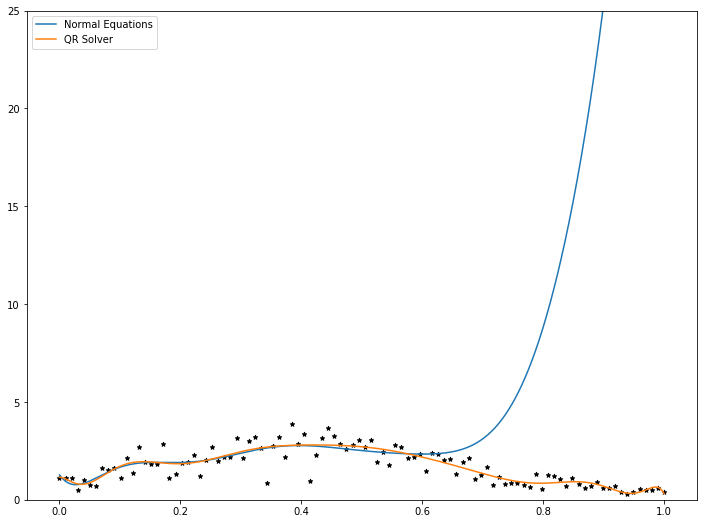

(152.14373083729365, 4.56837094170079)

In [45]:
def best_fit(n):
    xk, yk = np.load('../stability_data.npy').T
    A = np.vander(xk, n+1)
    x_unstable = la.inv(A.T@A)@A.T@yk
    Q, R = la.qr(A, mode='economic')
    x_stable = la.solve_triangular(R, Q.T@yk)
    domain = np.linspace(0, 1, 1000)
    plt.subplots(figsize=(12, 9))
    plt.plot(domain, np.polyval(x_unstable, domain), label='Normal Equations')
    plt.plot(domain, np.polyval(x_stable, domain), label='QR Solver')
    plt.scatter(xk, yk, marker='*', s=20, c='k')
    plt.legend()
    plt.ylim(0, 25)
    plt.show()
    return la.norm(A@x_unstable - yk), la.norm(A@x_stable - yk)
    
    
best_fit(14)

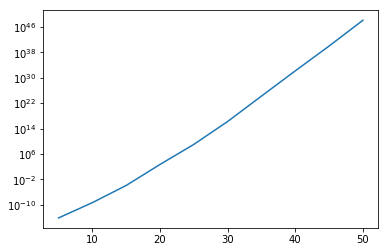

In [91]:
def integrate_comparison():
    x = sy.Symbol('x')
    true_vals = []
    fake_vals = []
    n_vals = list(range(5, 51, 5))
    for n in n_vals:
        true_vals.append(float(sy.integrate((x ** n) * (np.e ** (x - 1)), (x, 0, 1))))
        fake_vals.append(float(((-1) ** n) * sy.subfactorial(n) + ((-1) ** (n + 1)) * (sy.factorial(n) / np.e)))
    plt.plot(n_vals, np.absolute(np.array(true_vals) - np.array(fake_vals)))
    plt.yscale('log')
    plt.show()

integrate_comparison()

Clearly $10.6$ is not a stable way to compute $I(n)$, since for large $n$ it produces values that are vastly different from the true values as calculated by sy.integrate